In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from astropy.coordinates import SkyCoord
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, fit_multipole
import dipole

### inputs

In [3]:
# inputs used across the entire notebook
NSIDE = 64

# kwargs for each sample to pass to SecrestDipole() to load
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                      blim=30, maglim=16.4, load_init=False)
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=False, compcorrect=True)

### load sample

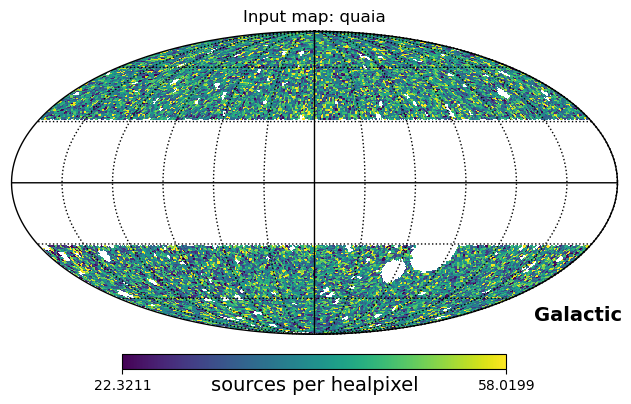

In [4]:
# load the source density table for the final sample (masked and density-corrected) and make healpix map
d = SecrestDipole(**quaia_kwargs)
tab = d.load_hpxelatcorr()

map_to_fit = np.empty(hp.nside2npix(NSIDE))
map_to_fit[:] = np.nan
map_to_fit[tab['hpidx']] = tab['elatdenscorr']
mean, std = np.nanmean(map_to_fit), np.nanstd(map_to_fit)
fig = plt.figure(figsize=(8,4))
hp.mollview(map_to_fit, coord=['C','G'], title=f'Input map: {d.catname}', unit='sources per healpixel',
            badcolor='w', min=mean-2*std, max=mean+2*std, fig=fig)
hp.graticule()

### compute $C_\ell$

In [5]:
def compute_Cells(amps):
    """
    Returns the power C(ell) for several ells given a list of amplitudes corresponding to the a_lm coefficients
    for each ell, increasing from ell=0.
    """
    ell = 0
    i1 = 0
    Cells = np.array([])
    while i1 < len(amps):
        i2 = i1 + 2 * ell + 1
        assert i2 <= len(amps)
        Cell = compute_Cell(amps[i1:i2])
        Cells = np.append(Cells, Cell)
        ell += 1
        i1 = i2
    return Cells

In [6]:
def compute_Cell(alms):
    """
    Returns the power C(ell) given a list of coefficients a_lm for a single ell.
    """
    assert alms.ndim <= 1
    # pad if aellems is a scalar:
    if alms.ndim == 0:
        alms = alms[..., np.newaxis]
    # infer ell from the number of moments 2ell+1
    ell = (len(alms) - 1) // 2
    assert np.mean(alms**2) == np.sum(alms**2)/(2*ell+1)
    return np.mean(alms**2)

In [7]:
# explore the dependence of the fit on the max ell

# choose a few max ells
max_ells = np.arange(1, 9)

ellss = []
Cellss = []
print("max ell:\t dipole amplitude:")
for i, max_ell in enumerate(max_ells):
    # simultaneously fit all low-ell amplitudes
    ells = np.arange(0, max_ell+1)
    ellss.append(ells)
    templates = construct_templates(ells, NSIDE=NSIDE)

    pars, stderr = fit_multipole(map_to_fit, templates, idx=~np.isnan(map_to_fit))
    
    print(f"{max_ell}\t\t {np.linalg.norm(pars[1:4]) / pars[0] * np.sqrt(3 / (4 * np.pi)) / (0.5 * np.sqrt(1/np.pi))}")
    
    # compute Cells, divide by monopole to make dimensionless
    Cellss.append(compute_Cells(pars / (0.5 * np.sqrt(1/np.pi) * pars[0])))

max ell:	 dipole amplitude:
1		 0.015594573433443849
2		 0.015393362826357554
3		 0.0358480466420219
4		 0.0374863004689576
5		 0.030070561365108214
6		 0.027851376645134495
7		 0.10147678190995028
8		 0.11489367870333722


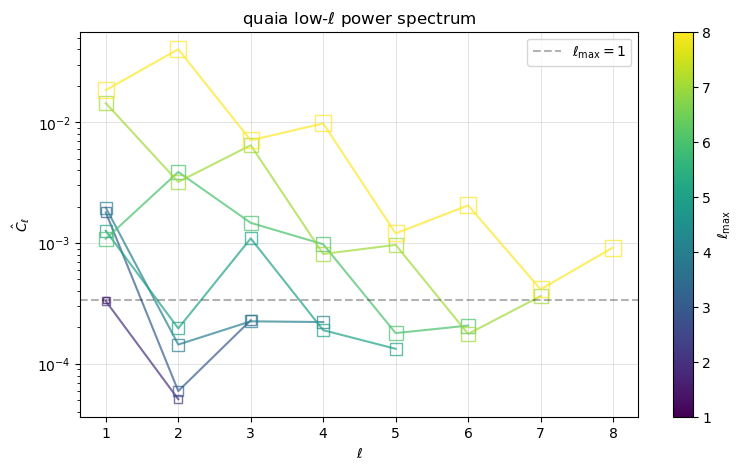

In [8]:
# plot
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')

fig, ax = plt.subplots(figsize=(9,5))

for i, max_ell in enumerate(max_ells):
    ax.plot(ellss[i][1:], Cellss[i][1:], marker='s', ms=4 * np.sqrt(max_ell), mfc='None', ls='-',
            alpha=0.7, c=smap.to_rgba(max_ell))
ax.semilogy()
ax.axhline(Cellss[0][1:], c='k', alpha=0.3, ls='--', label='$\ell_\mathrm{max}=1$')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xticks(np.arange(min(max_ells), max(max_ells)+1))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')
ax.set_title(f'{d.catname} low-'r'$\ell$ power spectrum')
fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$')
ax.legend()

In [9]:
assert False

AssertionError: 

In [ ]:
# plot
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')

fig, ax = plt.subplots(figsize=(9,5))

for i, max_ell in enumerate(max_ells):
    ax.plot(ellss[i][1:], Cellss[i][1:], marker='s', ms=4 * np.sqrt(max_ell), mfc='None', ls='-',
            alpha=0.7, c=smap.to_rgba(max_ell))
ax.semilogy()
ax.axhline(Cellss[0][1:], c='k', alpha=0.3, ls='--', label='$\ell_\mathrm{max}=1$')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xticks(np.arange(min(max_ells), max(max_ells)+1))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')
ax.set_title(f'{d.catname} low-'r'$\ell$ power spectrum')
fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$')
ax.legend()